<a href="https://colab.research.google.com/github/mi-molette/Backtest/blob/main/Cypher_LINK_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
!pip install python-binance
!pip install ta
!pip install talib-binary

<h1>Load yours data</h1>

In [51]:
# -- Import --
import pandas as pd
from binance.client import Client
import ta
import matplotlib.pyplot as plt
import numpy as np
import talib

# -- Define Binance Client --
client = Client()

# -- You can change the crypto pair ,the start date and the time interval below --
pairName = "LINKUSDT"
startDate = "01 september 2021"
timeInterval = Client.KLINE_INTERVAL_1HOUR

# -- Load all price data from binance API --
klinesT = client.get_historical_klines(pairName, timeInterval, startDate)
#affiche les 8 chiffres après la virgule
# pd.set_option('display.float_format', '{:.8f}'.format) 
# -- Define your dataset --
df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
df['close'] = pd.to_numeric(df['close'])
df['high'] = pd.to_numeric(df['high'])
df['low'] = pd.to_numeric(df['low'])
df['open'] = pd.to_numeric(df['open'])

# -- Set the date to index --
df = df.set_index(df['timestamp'])
df.index = pd.to_datetime(df.index, unit='ms')
del df['timestamp']

print("Data loaded 100%")

print(df[['close']].tail(5))


# -- Uncomment the line below if you want to check your price dataset --
# df

Data loaded 100%
                     close
timestamp                 
2022-02-10 14:00:00  18.10
2022-02-10 15:00:00  18.16
2022-02-10 16:00:00  18.31
2022-02-10 17:00:00  18.13
2022-02-10 18:00:00  18.17


<h1>Define your indicators</h1>

In [52]:
#@title
# -- Drop all columns we do not need --
df.drop(df.columns.difference(['open','high','low','close','volume']), 1, inplace=True)
df['EMA24']=ta.trend.ema_indicator(df['close'], window=24)
df['EMA50']=ta.trend.ema_indicator(df['close'], window=50)
df['EMA200']=ta.trend.ema_indicator(df['close'], window=200)

df['MACD']=ta.trend.macd_diff(df['close'],26,12,30)
df['MACD_DIFF']= df['MACD'].diff(1)

df['MACD2']=ta.trend.macd_diff(df['close'],9,4,30)
df['MACD2_DIFF']= df['MACD2'].diff(1)

# -- Stochasitc RSI --
df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=14, smooth1=1, smooth2=1)


# -- Cipher B --
channelLength = 9
averageLength = 12
high = df['high']
low = df['low']
close = df['close']

ap = (high + low + close) / 3 
esa = ta.trend.ema_indicator(ap, channelLength)
d = ta.trend.ema_indicator(abs(ap - esa), channelLength)
ci = (ap - esa) / (0.015 * d)
tci = ta.trend.ema_indicator(ci, averageLength)

wt1 = tci
wt2 = ta.trend.sma_indicator(wt1, 4)

df['wt1'] = wt1
df['wt2'] = wt2

#// RSI+MFI Parameters  (MONEYFLOW)
rsiMFIperiod = 60 # 'MFI Period'
rsiMFIMultiplier = 150 # 'MFI Area multiplier'
rsiMFIPosY = 2.5 # 'MFI Area Y Pos' 2.5

high = df['high']
low = df['low']
close = df['close']
open = df['open']

rsimfi = (close - open) / (high - low) 
rsimfisma = (ta.trend.sma_indicator(rsimfi, rsiMFIperiod) * rsiMFIMultiplier ) - rsiMFIPosY 
df['moneyflow'] = rsimfisma



#// MMA50 PULLBACK = -1 WHEN PRICE GOING BACK UNDER  MMA50
df['EMA50PULLBACK'] = 0

for index, row in df.iterrows():
  if row['close'] > row['EMA50']:
    df.at[index,'EMA50PULLBACK'] = 1
    previousEMA50PULLBACK = 1
  elif row['close'] < row['EMA50'] and (previousEMA50PULLBACK == 1 or previousEMA50PULLBACK == -1) :
    df.at[index,'EMA50PULLBACK'] = -1
    previousEMA50PULLBACK = -1
  elif row['close'] < row['EMA50'] and previousEMA50PULLBACK == 0 :
    previousEMA50PULLBACK = 0

#MIN DES 5 DERNIERE HEURES:
df['close5hmin'] = df['close'].rolling(5).min()

print("Indicators loaded 100%")








/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


Indicators loaded 100%


<h1>RUN the Spot Backtest</h1>

None
BackTest finished, final wallet : 1014.0874108649065 $
                                   date position  ... resultat%  tradeIs
date                                              ...                   
2022-02-02 02:00:00 2022-02-02 02:00:00      Buy  ...       NaN         
2022-02-02 08:00:00 2022-02-02 08:00:00     Sell  ...  0.164715     Good
2022-02-06 18:00:00 2022-02-06 18:00:00      Buy  ...       NaN         
2022-02-06 23:00:00 2022-02-06 23:00:00     Sell  ...  3.067072     Good
2022-02-08 18:00:00 2022-02-08 18:00:00      Buy  ...       NaN         
2022-02-09 02:00:00 2022-02-09 02:00:00     Sell  ... -0.622405      Bad
2022-02-09 07:00:00 2022-02-09 07:00:00      Buy  ...       NaN         
2022-02-09 18:00:00 2022-02-09 18:00:00     Sell  ...  1.747911     Good
2022-02-10 08:00:00 2022-02-10 08:00:00      Buy  ...       NaN         
2022-02-10 13:00:00 2022-02-10 13:00:00     Sell  ... -3.344604      Bad

[10 rows x 12 columns]
Pair Symbol : LINKUSDT
Period : [2021-09

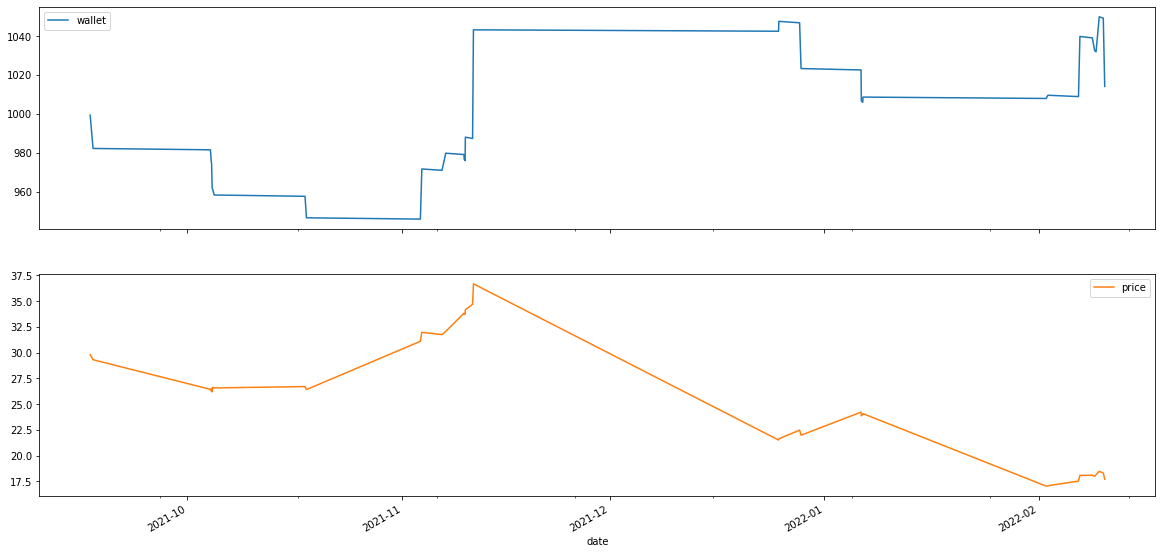

In [53]:
dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df  #'2021-11-10'
# dfTest = df['2021-09-01':]  #'2021-11-10'

# -- Definition of dt, that will be the dataset to do your trades analyses --
dt = None
print(dt)

dt = pd.DataFrame(columns = ['date','position', 'reason', 'price', 'frais' ,'fiat', 'coins', 'wallet', 'drawBack'])

# -- You can change variables below --
usdt = 1000
makerFee = 0.0002
takerFee = 0.0007

# -- Do not touch these values --
initalWallet = usdt
wallet = usdt
coin = 0
lastAth = 0
previousRow = dfTest.iloc[0]
stopLoss = 0
takeProfit = 0
stopLossLevel = 0.95  ##########################################
takeProfitLevel = 3
buyReady = True
sellReady = True

occur = 0   #nb de good trade 
wait = 0
tradeIs = True
occurBad = 0

# Rules
# LONG si close > EMA200 SHORT si close<EMA 200 
# LONG ONLY IF PULLBACK INTO EMA50 (previousrow[close] >EMA50 et row[close]< EMA50)
# AND MONEYFLOW > 0  AND WLLT1 < 0  
# AND WLLT1 CROSS WLLT 2
# STOPLOSS =  MIN OF 5H et TAKEPROFIT = 3* STOPLOSS


def buyCondition(row, previousrow):
    if (
        row['close'] > row['EMA200']                           # LONG si close > EMA200
        and row['EMA50PULLBACK'] == -1                      # PULLBACK INTO EMA50
        and row['moneyflow'] > 0 and row['wt1'] < 0             # AND MONEYFLOW > 0  AND WLLT1 < 0  
        and row['wt1'] > row['wt2']                           # AND WLLT1 CROSS WLLT 2
        ) :
        return True
    else:
        return False

def sellCondition(row, previousrow):
    if row['wt1'] < previousrow['wt2']  :
        return True
    else:
      return False

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():
  # -- Buy market order --
  if buyCondition(row, previousRow) and usdt > 0 and buyReady == True  :
    # -- You can define here at what price you buy --
    buyPrice = row['close']

    # -- Define the price of you SL and TP or comment it if you don't want a SL or TP --
    stopLoss = row['close5hmin']
    takeProfit = row['close']+(row['close']-stopLoss)*3

    coin = usdt / buyPrice
    fee = takerFee * coin
    coin = coin - fee
    usdt = 0
    wallet = coin * row['close']

    # -- Check if your wallet hit a new ATH to know the drawBack --
    if wallet > lastAth:
      lastAth = wallet

    # -- You can uncomment the line below if you want to see logs --
    # print("Buy COIN at",buyPrice,'$ the', index)

    # -- Add the trade to DT to analyse it later --
    myrow = {'date': index, 'position': "Buy", 'reason':'Buy Market Order','price': buyPrice,'frais': fee,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)
  
  # -- Stop Loss --
  elif row['close'] < stopLoss and coin > 0:
    sellPrice = row['close']
    usdt = coin * sellPrice
    fee = takerFee * usdt
    usdt = usdt - fee
    coin = 0
    buyReady = True
    wallet = usdt
    tradeIs = False
    # -- Check if your wallet hit a new ATH to know the drawBack --
    if wallet > lastAth:
      lastAth = wallet
      
    # -- You can uncomment the line below if you want to see logs --
    # print("Sell COIN at Stop Loss",sellPrice,'$ the', index)

    # -- Add the trade to DT to analyse it later --
    myrow = {'date': index,'position': "Sell", 'reason':'Sell Stop Loss','price': sellPrice,'frais': fee,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)    

# -- Take profit --
  elif row['close'] > takeProfit and coin > 0:
    sellPrice = row['close']
    usdt = coin * sellPrice
    fee = takerFee * usdt
    usdt = usdt - fee
    coin = 0
    buyReady = True
    wallet = usdt

    # -- Check if your wallet hit a new ATH to know the drawBack --
    if wallet > lastAth:
      lastAth = wallet
      
    # -- You can uncomment the line below if you want to see logs --
    # print("Sell COIN at Stop Loss",sellPrice,'$ the', index)

    # -- Add the trade to DT to analyse it later --
    myrow = {'date': index,'position': "Sell", 'reason':'Sell Take Profit','price': sellPrice,'frais': fee,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)    

  # -- Sell Market Order --
  elif sellCondition(row, previousRow) and coin > 0 and sellReady == True:

    # -- You can define here at what price you buy --
    sellPrice = row['close']
    usdt = coin * sellPrice
    fee = takerFee * usdt
    usdt = usdt - fee
    coin = 0
    buyReady = True
    wallet = usdt


    # -- Check if your wallet hit a new ATH to know the drawBack --
    if wallet > lastAth:
      lastAth = wallet

    # -- You can uncomment the line below if you want to see logs --  
    # print("Sell COIN at",sellPrice,'$ the', index)

    # -- Add the trade to DT to analyse it later --
    myrow = {'date': index,'position': "Sell", 'reason':'Sell Market Order','price': sellPrice,'frais': fee,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)
     

  previousRow = row




# -- BackTest Analyses --
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat'] = dt['wallet'].diff()
dt['resultat%'] = dt['wallet'].pct_change()*100
dt.loc[dt['position']=='Buy','resultat'] = None
dt.loc[dt['position']=='Buy','resultat%'] = None

dt['tradeIs'] = ''
dt.loc[dt['resultat']>0,'tradeIs'] = 'Good'
dt.loc[dt['resultat']<=0,'tradeIs'] = 'Bad'

iniClose = dfTest.iloc[0]['close']
lastClose = dfTest.iloc[len(dfTest)-1]['close']
holdPercentage = ((lastClose - iniClose)/iniClose) * 100
algoPercentage = ((wallet - initalWallet)/initalWallet) * 100
vsHoldPercentage = ((algoPercentage - holdPercentage)/holdPercentage) * 100
iddraw = dt.drawBack.idxmin()
drawbackvalue = round((dt[dt.drawBack == dt.drawBack.min()]['wallet']) - ((dt[dt.drawBack == dt.drawBack.min()]['wallet']) * (1/(1+round(dt['drawBack'].min(), 2)))),-1)
try:
    tradesPerformance = round(dt.loc[(dt['tradeIs'] == 'Good') | (dt['tradeIs'] == 'Bad'), 'resultat%'].sum()
            / dt.loc[(dt['tradeIs'] == 'Good') | (dt['tradeIs'] == 'Bad'), 'resultat%'].count(), 2)
except:
    tradesPerformance = 0
    print("/!\ There is no Good or Bad Trades in your BackTest, maybe a problem...")

try:
    totalGoodTrades = dt.groupby('tradeIs')['date'].nunique()['Good']
    AveragePercentagePositivTrades = round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].sum()
                                           / dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].count(), 2)
    idbest = dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].idxmax()
    bestTrade = str(
        round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].max(), 2))
except:
    totalGoodTrades = 0
    AveragePercentagePositivTrades = 0
    idbest = ''
    bestTrade = 0
    print("/!\ There is no Good Trades in your BackTest, maybe a problem...")

try:
    totalBadTrades = dt.groupby('tradeIs')['date'].nunique()['Bad']
    AveragePercentageNegativTrades = round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].sum()
                                           / dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].count(), 2)
    idworst = dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].idxmin()
    worstTrade = round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].min(), 2)
except:
    totalBadTrades = 0
    AveragePercentageNegativTrades = 0
    idworst = ''
    worstTrade = 0
    print("/!\ There is no Bad Trades in your BackTest, maybe a problem...")

totalTrades = totalBadTrades + totalGoodTrades
winRateRatio = (totalGoodTrades/totalTrades) * 100

reasons = dt['reason'].unique()

print("BackTest finished, final wallet :",wallet,"$")


print(dt.tail(10))
# print(dt['price'].iloc[-1] * 0.9)
# print(df['close'].tail(5))




#print("\n----- Result array -----\n")
#@title
print("Pair Symbol :",pairName)
print("Period : [" + str(dfTest.index[0]) + "] -> [" +
      str(dfTest.index[len(dfTest)-1]) + "]")
print("Starting balance :", initalWallet, "$")

print("\n----- General Informations -----")
print("Final balance :", round(wallet, 2), "$")
print("Performance vs US Dollar :", round(algoPercentage, 2), "%")
print("Buy and Hold Performence :", round(holdPercentage, 2), "%")
print("Performance vs Buy and Hold :", round(vsHoldPercentage, 2), "%")
print("Best trade : +"+bestTrade, "%, the", idbest)
print("Worst trade :", worstTrade, "%, the", idworst)
print("Worst drawBack :", str(100*round(dt['drawBack'].min(), 1)), "% @", drawbackvalue )

print("Total fees : ", round(dt['frais'].sum(), 2), "$")

print("\n----- Trades Informations -----")
print("Total trades on period :",totalTrades)
print("Number of positive trades :", totalGoodTrades)
print("Number of negative trades : ", totalBadTrades)
print("Trades win rate ratio :", round(winRateRatio, 2), '%')
print("Average trades performance :",tradesPerformance,"%")
print("Average positive trades :", AveragePercentagePositivTrades, "%")
print("Average negative trades :", AveragePercentageNegativTrades, "%")

print("\n----- Trades Reasons -----")
reasons = dt['reason'].unique()
for r in reasons:
    print(r+" number :", dt.groupby('reason')['date'].nunique()[r])


print("\n----- Result array -----\n")

dt[['wallet', 'price']].plot(subplots=True, figsize=(20, 10))
print("\n----- Plot -----")
